In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_4.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["matrixSize"] = dataFrame["matrixSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Matrix sizes:", sorted(dataFrame["matrixSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 250
Modes: ['blockRow' 'cannon']
Matrix sizes: [240, 480, 720, 960, 1200]
Process counts: [1, 4, 9, 16, 25]


,testType,matrixSize,numProcesses,mode,timeSeconds,checksum,runIndex,mpiEnv
0,MPI_4,240,1,blockRow,0.001981,3.455693e+06,1,PROCS=1
1,MPI_4,240,1,blockRow,0.001961,3.459653e+06,2,PROCS=1
2,MPI_4,240,1,blockRow,0.002159,3.461780e+06,3,PROCS=1
3,MPI_4,240,1,blockRow,0.001968,3.473794e+06,4,PROCS=1
4,MPI_4,240,1,blockRow,0.001931,3.449937e+06,5,PROCS=1
5,MPI_4,240,1,cannon,0.002307,3.454358e+06,1,PROCS=1
6,MPI_4,240,1,cannon,0.002265,3.447258e+06,2,PROCS=1
7,MPI_4,240,1,cannon,0.002270,3.448141e+06,3,PROCS=1


In [3]:
groupedFrame = dataFrame.groupby(["mode","matrixSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","matrixSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,mode,matrixSize,numProcesses,median,mean,std,count
0,blockRow,240,1,0.001968,0.002000,0.000091,5
1,blockRow,240,4,0.000952,0.001031,0.000174,5
2,blockRow,240,9,0.001302,0.001320,0.000059,5
3,blockRow,240,16,0.002451,0.002394,0.000092,5
4,blockRow,240,25,0.004045,0.004010,0.000134,5
5,blockRow,480,1,0.014222,0.014217,0.000030,5
6,blockRow,480,4,0.004980,0.005052,0.000205,5
7,blockRow,480,9,0.005443,0.005390,0.000180,5
8,blockRow,480,16,0.007441,0.007515,0.000392,5
9,blockRow,480,25,0.013249,0.012764,0.001770,5


In [ ]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, matrixSizeVal), subFrame in groupedDf.groupby(["mode","matrixSize"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,mode,matrixSize,numProcesses,median,mean,std,count,speedup,efficiency
0,blockRow,240,1,0.001968,0.002000,0.000091,5,1.000000,1.000000
1,blockRow,240,4,0.000952,0.001031,0.000174,5,2.067227,0.516807
2,blockRow,240,9,0.001302,0.001320,0.000059,5,1.511521,0.167947
3,blockRow,240,16,0.002451,0.002394,0.000092,5,0.802938,0.050184
4,blockRow,240,25,0.004045,0.004010,0.000134,5,0.486527,0.019461
5,blockRow,480,1,0.014222,0.014217,0.000030,5,1.000000,1.000000
6,blockRow,480,4,0.004980,0.005052,0.000205,5,2.855823,0.713956
7,blockRow,480,9,0.005443,0.005390,0.000180,5,2.612897,0.290322
8,blockRow,480,16,0.007441,0.007515,0.000392,5,1.911302,0.119456
9,blockRow,480,25,0.013249,0.012764,0.001770,5,1.073440,0.042938


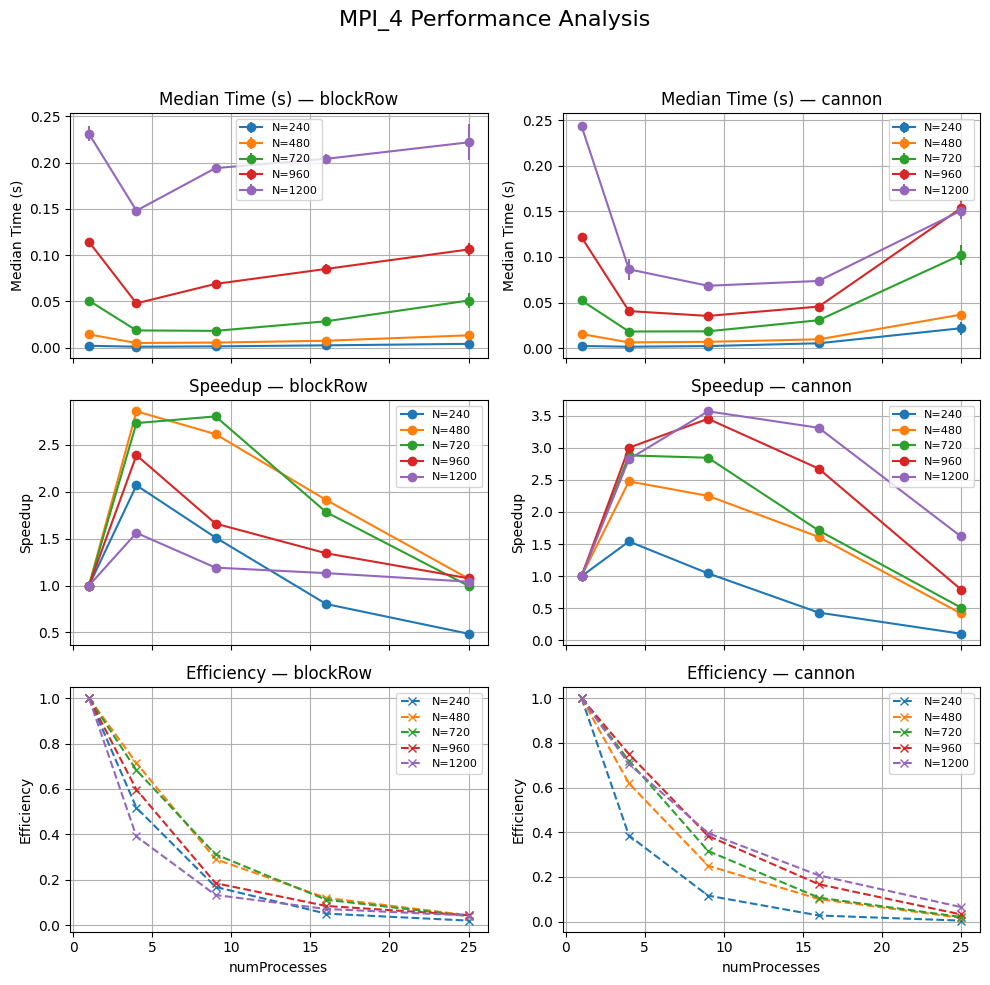

In [7]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

matrixSizes = sorted(perfFrame["matrixSize"].unique())

fig, axes = plt.subplots(len(metrics), len(modes), figsize=(5 * max(1, len(modes)), 10), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for matrixSizeVal in matrixSizes:
            subFrame = perfFrame[(perfFrame["mode"] == modeVal) & (perfFrame["matrixSize"] == matrixSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values if "std" in subFrame.columns else None
                if yerr is not None:
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
                else:
                    ax.plot(x, y, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={matrixSizeVal}")

        if not anyPlotted:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == len(metrics) - 1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_4 Performance Analysis", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [8]:
summaryRows = []
for (modeVal, matrixSizeVal), sub in perfFrame.groupby(["mode","matrixSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "matrixSize": matrixSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Proc": medianAtOne
    })

summaryFrame = pd.DataFrame(summaryRows).sort_values(["mode","matrixSize"])
display(summaryFrame)


,mode,matrixSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Proc
0,blockRow,240,4,2.067227,0.516807,0.001968
1,blockRow,480,4,2.855823,0.713956,0.014222
2,blockRow,720,9,2.801691,0.311299,0.050705
3,blockRow,960,4,2.387881,0.596970,0.114284
4,blockRow,1200,4,1.560871,0.390218,0.231051
5,cannon,240,4,1.540027,0.385007,0.002270
6,cannon,480,4,2.475249,0.618812,0.015401
7,cannon,720,4,2.879586,0.719896,0.052276
8,cannon,960,9,3.449388,0.383265,0.121722
9,cannon,1200,9,3.565803,0.396200,0.243851
